#### Import libraries / dataset / split data / encoder

In [36]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
import time



import warnings


warnings.filterwarnings('ignore')        

In [37]:
data = 'dataset/car_evaluation.csv'

df = pd.read_csv(data, header=None)
# view dimensions of dataset

df.shape

(1728, 7)

In [38]:
# preview the dataset

df.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [39]:
col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']


df.columns = col_names

col_names

['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

In [40]:
# let's again preview the dataset
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [42]:
col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']


for col in col_names:
    
    print(df[col].value_counts())   

buying
vhigh    432
high     432
med      432
low      432
Name: count, dtype: int64
maint
vhigh    432
high     432
med      432
low      432
Name: count, dtype: int64
doors
2        432
3        432
4        432
5more    432
Name: count, dtype: int64
persons
2       576
4       576
more    576
Name: count, dtype: int64
lug_boot
small    576
med      576
big      576
Name: count, dtype: int64
safety
low     576
med     576
high    576
Name: count, dtype: int64
class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64


In [43]:
class_counts=df['class'].value_counts()
print(class_counts)

class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64


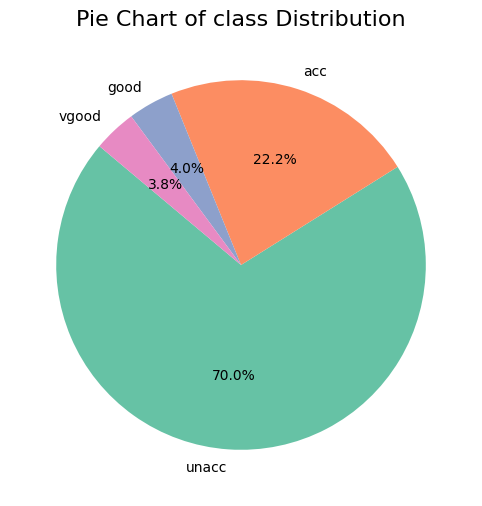

In [44]:
plt.figure(figsize=(8, 6))
plt.pie(
    class_counts,
    labels=class_counts.index,
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("Set2"),
)
plt.title("Pie Chart of class Distribution", fontsize=16)
plt.show()

In [45]:
df.isnull().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

In [46]:
X = df.drop(['class'], axis=1)

y = df['class']

# split data into training and testing sets


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

# check the shape of X_train and X_test

X_train.shape, X_test.shape

((1382, 6), (346, 6))

In [47]:
# check data types in X_train

X_train.dtypes

buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
dtype: object

In [48]:
X_train.head()

,buying,maint,doors,persons,lug_boot,safety
107,vhigh,vhigh,5more,more,big,high
901,med,vhigh,3,4,small,med
1709,low,low,5more,2,big,high
706,high,med,4,2,med,med
678,high,med,3,2,med,low


In [49]:
import category_encoders as ce
# encode categorical variables with ordinal encoding

encoder = ce.OrdinalEncoder(cols=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])


X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

X_train.head()


,buying,maint,doors,persons,lug_boot,safety
107,1,1,1,1,1,1
901,2,1,2,2,2,2
1709,3,2,1,3,1,1
706,4,3,3,3,3,2
678,4,3,2,3,3,3


In [50]:
X_test.head()


,buying,maint,doors,persons,lug_boot,safety
599,4,4,3,3,3,1
1201,2,2,4,2,3,2
628,4,4,1,3,1,2
1498,3,4,1,2,3,2
1263,2,2,3,1,3,3


#### Attempt 1: Using Grid Search to find the best parameters for our model

In [51]:
# Parameter Grid
param_options = {
    "criterion": ["gini", "entropy"],  # Function to measure the quality of a split
    "max_features": [1, 6, 'sqrt', 'log2', None],  # Number of features to consider at every split
    "max_depth": [None, 10, 20, 30],  # Maximum number of levels in tree
    # "bootstrap": [True, False]  # Method of selecting samples for training each tree
}

# GridSearchCV
start_time = time.time()
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(n_estimators=1000),
    param_grid=param_options,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)  # Fit GridSearchCV to the data
end_time = time.time()
grid_search_time = end_time - start_time



# Results
best_params_grid = grid_search.best_params_
best_score_grid = grid_search.best_score_

# Print the results
print(f"Grid Search took {grid_search_time:.2f} seconds.")
print("Grid Search Best Parameters:", best_params_grid)
print("Grid Search Best Score:", best_score_grid)



# Compare the best scores from both searches and select the best parameters
best_params = best_params_grid
     

Grid Search took 30.23 seconds.
Grid Search Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 6}
Grid Search Best Score: 0.9710589651022865


#### 1-1 Training Data with default hyperparameters


In [55]:
# import Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
# instantiate the classifier 
rfc = RandomForestClassifier(random_state=0)


start_time = time.time()

# fit the model
rfc.fit(X_train, y_train)
# Predict the Test set results
y_pred = rfc.predict(X_test)

end_time = time.time()
rf_best_time = end_time - start_time

# Check accuracy score 

print('Model accuracy score with default hyperparameters : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print(f"training took {rf_best_time:.2f} seconds.")

Model accuracy score with default hyperparameters : 0.9624
training took 0.14 seconds.


#### 1-2 Training Data with custom hyperparameters

In [56]:
rf_best = RandomForestClassifier(**best_params, random_state=0)

start_time = time.time()

# Fit the model to the training data
rf_best.fit(X_train, y_train)
y_pred = rf_best.predict(X_test)

end_time = time.time()
rf_best_time = end_time - start_time

accuracy = accuracy_score(y_test, y_pred)

print("best_params:", best_params)
print(f"Accuracy: {accuracy:.4f}")
print(f"training took {rf_best_time:.2f} seconds.")

best_params: {'criterion': 'entropy', 'max_depth': None, 'max_features': 6}
Accuracy: 0.9711
training took 0.14 seconds.


#### Attempt 2: Feature Importance and train again

In [181]:
# view the feature scores

feature_scores = pd.Series(rf_best.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

safety      0.255544
persons     0.218942
maint       0.172905
buying      0.171879
lug_boot    0.120408
doors       0.060322
dtype: float64

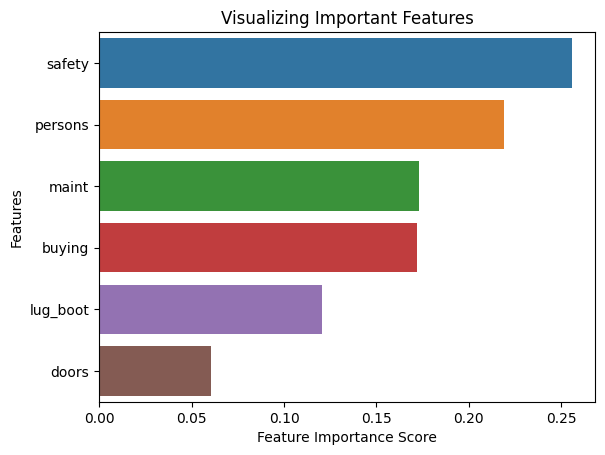

In [182]:
# Creating a seaborn bar plot

sns.barplot(x=feature_scores, y=feature_scores.index)



# Add labels to the graph

plt.xlabel('Feature Importance Score')

plt.ylabel('Features')



# Add title to the graph

plt.title("Visualizing Important Features")



# Visualize the graph

plt.show()

#### Finall Results

In [261]:
# Print the Confusion Matrix and slice it into four pieces


cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[113  13   2   1]
 [  0  19   0   1]
 [  5   0 392   0]
 [  3   0   0  22]]


In [262]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         acc       0.93      0.88      0.90       129
        good       0.59      0.95      0.73        20
       unacc       0.99      0.99      0.99       397
       vgood       0.92      0.88      0.90        25

    accuracy                           0.96       571
   macro avg       0.86      0.92      0.88       571
weighted avg       0.96      0.96      0.96       571



#### Attempt 3: Using custome hyperparameters(disscussed in class of machine learning) for our model

In [ ]:
rf_default = RandomForestClassifier(n_estimators = 1000, max_features = 1) # (1, nd)

start_time = time.time()

# Fit the model to the training data
rf_default.fit(X_train, y_train)
y_pred = rf_default.predict(X_test)

end_time = time.time()
rf_default_time = end_time - start_time

accuracy = accuracy_score(y_test, y_pred)

# Manually select and display the desired parameters
selected_params = {
    'bootstrap': rf_default.bootstrap,
    'criterion': rf_default.criterion,
    'max_depth': rf_default.max_depth,
    'max_features': rf_default.max_features,
    'n_estimators': rf_default.n_estimators
}

print("Selected params:", selected_params)
print(f"Accuracy: {accuracy:.2f}")
print(f"training took {rf_default_time:.2f} seconds.")

Selected params: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'n_estimators': 1000}
Accuracy: 0.94
training took 1.46 seconds.
